In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import h5py

# Square box periodic

In [2]:
# Set up trajectory parameters
dt = 0.02  # time step increment (seconds)
samples = 10  # number of time points
box_size = 1.1 #meters

sigma = 5.76 * 2  # stdev rotation velocity (rads/sec)
b = 0.13 * 2 * np.pi # forward velocity rayleigh dist scale (m/sec)
mu = 0  # turn angle bias 

In [17]:
b

0.8168140899333463

In [18]:
def generate_trajectory(dt, samples, box_size, sigma, b, mu):
    '''Generate a random walk in a square, periodic box'''
    # Initialize variables
    position = np.zeros([samples+2, 2])
    head_dir = np.zeros(samples+2)
    turning = np.zeros(samples+2, dtype='bool')
    position[0] = np.random.uniform(-box_size, box_size, 2)
    head_dir[0] = np.random.uniform(0,2*np.pi)
    velocity = np.zeros(samples+2)
    
    # Generate sequence of random boosts and turns
    random_turn = np.random.normal(mu, sigma, samples+2)
#     random_vel = np.random.rayleigh(b, samples+2)
    b = 1  # m/sec
    random_vel = np.abs(np.random.normal(0, b, samples+2))
    
    for i in range(samples+1):
        #Take a step
        v = random_vel[i]
        velocity[i] = v*dt
        update = velocity[i]*np.asarray([np.cos(head_dir[i]), np.sin(head_dir[i])])
        position[i+1] = position[i] + update
        
        #Rotate head direction
        turn_angle = dt*random_turn[i]
        head_dir[i+1] = (head_dir[i] + turn_angle)
        
    position = np.mod(position + box_size, 2*box_size) - box_size  # Periodic boundaries 
    head_dir = np.mod(head_dir + np.pi, 2*np.pi) - np.pi # Periodic variable
       
    traj = {}
    # Input variables
    traj['init_hd'] = head_dir[0]
    traj['init_x'] = position[1,0]
    traj['init_y'] = position[1,1]
    
    traj['ego_v'] = velocity[1:-1]
    ang_v = np.diff(head_dir)
    traj['phi_x'], traj['phi_y'] = np.cos(ang_v)[:-1], np.sin(ang_v)[:-1]
    
    # Target variables
    traj['target_hd'] = head_dir[1:-1]
    traj['target_x'] = position[2:,0]
    traj['target_y'] = position[2:,1]
    
    return traj

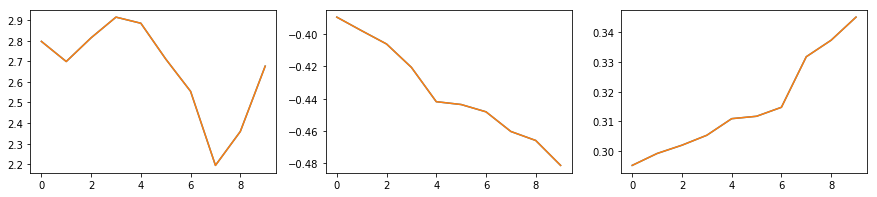

In [19]:
# Manually check path integration
traj = generate_trajectory(dt, samples, box_size, sigma, b, mu)

phi = np.arctan2(traj['phi_y'], traj['phi_x'])
phi = np.mod(phi + np.pi, 2*np.pi) - np.pi
hd_est = traj['init_hd'] + np.cumsum(phi)
x_est = traj['init_x'] + np.cumsum(traj['ego_v']*np.cos(hd_est))
x_est = np.mod(x_est + box_size, 2*box_size) - box_size
y_est = traj['init_y'] + np.cumsum(traj['ego_v']*np.sin(hd_est))
y_est = np.mod(y_est + box_size, 2*box_size) - box_size

plt.figure(figsize=(15,3))
plt.subplot(131)
plt.plot(traj['target_hd'])
plt.plot(hd_est)
plt.subplot(132)
plt.plot(traj['target_x'])
plt.plot(x_est)
plt.subplot(133)
plt.plot(traj['target_y'])
plt.plot(y_est)
plt.show()

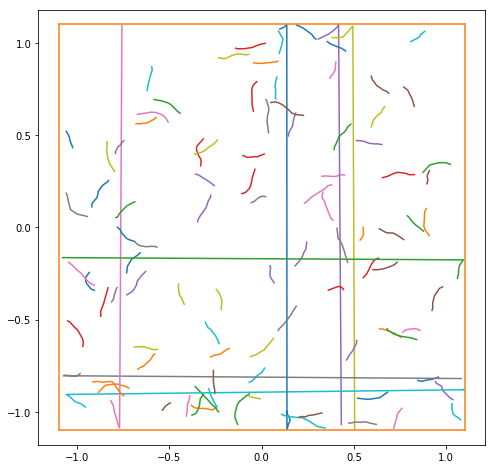

In [21]:
def plot_sample_trajs(num_traj):
    plt.figure(figsize=(8,8))
    for i in range(num_traj):
        traj = generate_trajectory(dt, samples, box_size, sigma, b, mu)
        x = traj['target_x']
        y = traj['target_y']
        plt.plot(x, y)

    # Plot box
    plt.axis("equal")    
    plt.plot(np.linspace(-box_size, box_size, 2),np.ones(2)*-box_size, c='C1')
    plt.plot(np.linspace(-box_size, box_size, 2),np.ones(2)*box_size, c='C1')
    plt.plot(np.ones(2)*-box_size,np.linspace(-box_size, box_size, 2), c='C1')
    plt.plot(np.ones(2)*box_size,np.linspace(-box_size, box_size, 2), c='C1')
    
plot_sample_trajs(100)

In [22]:
# Generate and save dataset
num_files = 100
num_trajectories = 100
data_name = '10_step_periodic_normal'
datafile = 'data/' + data_name

# Make directory
import os
if not os.path.exists(datafile):
    os.mkdir(datafile)

def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

for i in tqdm(range(num_files)):
    filename = datafile + '/' + str(i) + '.tfrecord'
    with tf.python_io.TFRecordWriter(filename) as writer:
        for j in range(num_trajectories):
            traj = generate_trajectory(dt, samples, box_size, sigma, b, mu)
            feature = {
                'init_x': _floats_feature([traj['init_x']]),
                'init_y': _floats_feature([traj['init_y']]),
                'init_hd': _floats_feature([traj['init_hd']]),
                'ego_v': _floats_feature(traj['ego_v']),
                'phi_x': _floats_feature(traj['phi_x']),
                'phi_y': _floats_feature(traj['phi_y']),
                'target_x': _floats_feature(traj['target_x']),
                'target_y': _floats_feature(traj['target_y']),
                'target_hd': _floats_feature(traj['target_hd'])
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())


# Square box finite

In [5]:
def min_dist_angle(position, direction, box_size):
    #which wall is it close to?
    x, y = position
    dists = [box_size-x, box_size-y, box_size+x, box_size+y]
    d_wall = np.min(dists)
    angles = np.arange(4)*np.pi/2
    theta = angles[np.argmin(dists)]
    a_wall = direction - theta
    a_wall = (a_wall + np.pi) % (2*np.pi) - np.pi
    return d_wall, a_wall

In [24]:
# Set up trajectory parameters
dt = 0.02  # time step increment (seconds)
samples = 10  # number of time points
box_size = 1.1 #meters

sigma = 5.76 * 2  # stdev rotation velocity (rads/sec)
b = 0.13 * 2 * np.pi # forward velocity rayleigh dist scale (m/sec)
mu = 0  # turn angle bias 

border_region = 0.03  # meters

In [25]:
# random velocity samples
def generate_trajectory(dt, samples, box_size, sigma, b, mu):
    #initialize variables
    position = np.zeros([samples+2, 2])
    head_dir = np.zeros(samples+2)
    position[0] = np.random.uniform(-box_size, box_size, 2)
    head_dir[0] = np.random.uniform(0,2*np.pi)
    velocity = np.zeros(samples+2)
    
    #generate sequence of random boosts and turns
    random_turn = np.random.normal(mu, sigma, samples+1)
    random_vel = np.random.rayleigh(b, samples+1)
    v = np.random.rayleigh(b, 1)
    
    # stop at random times for 10 iters
#     stop_idx = np.random.randint(samples)
#     random_vel[stop_idx:stop_idx+5] = 0
    
    for i in range(samples+1):
        # If in border region, turn and slow down
        d_wall, a_wall = min_dist_angle(position[i], head_dir[i] % (2*np.pi), box_size)
        if d_wall < border_region and np.abs(a_wall) < np.pi/2:
            turn_angle = np.sign(a_wall) * (np.pi/2 - np.abs(a_wall)) + dt*random_turn[i]
            v = 0.25*v
        else:
            v = random_vel[i]
            turn_angle = dt*random_turn[i]
            
        #Take a step
        velocity[i] = v*dt
        update = velocity[i]*np.asarray([np.cos(head_dir[i]), np.sin(head_dir[i])])
        position[i+1] = position[i] + update
        
        #Rotate head direction
        head_dir[i+1] = head_dir[i] + turn_angle
        
    traj = {}
    # Input variables
    traj['init_hd'] = head_dir[0]
    traj['init_x'] = position[1,0]
    traj['init_y'] = position[1,1]
    
    traj['ego_v'] = velocity[1:-1]
    ang_v = np.diff(head_dir)
    traj['phi_x'], traj['phi_y'] = np.cos(ang_v)[:-1], np.sin(ang_v)[:-1]
    
    # Target variables
    traj['target_hd'] = head_dir[1:-1]
    traj['target_x'] = position[2:,0]
    traj['target_y'] = position[2:,1]
    
    return traj

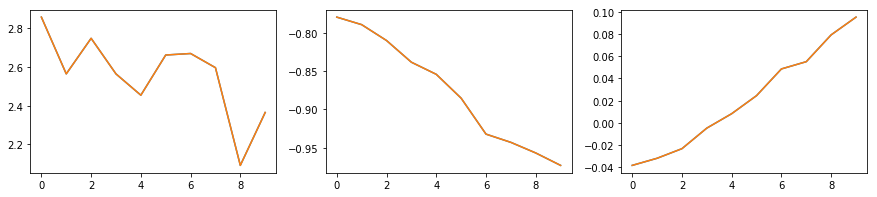

In [26]:
# Manually check path integration
traj = generate_trajectory(dt, samples, box_size, sigma, b, mu)

phi = np.arctan2(traj['phi_y'], traj['phi_x'])
phi = np.mod(phi + np.pi, 2*np.pi) - np.pi
hd_est = traj['init_hd'] + np.cumsum(phi)
x_est = traj['init_x'] + np.cumsum(traj['ego_v']*np.cos(hd_est))
x_est = np.mod(x_est + box_size, 2*box_size) - box_size
y_est = traj['init_y'] + np.cumsum(traj['ego_v']*np.sin(hd_est))
y_est = np.mod(y_est + box_size, 2*box_size) - box_size

plt.figure(figsize=(15,3))
plt.subplot(131)
plt.plot(traj['target_hd'])
plt.plot(hd_est)
plt.subplot(132)
plt.plot(traj['target_x'])
plt.plot(x_est)
plt.subplot(133)
plt.plot(traj['target_y'])
plt.plot(y_est)
plt.show()

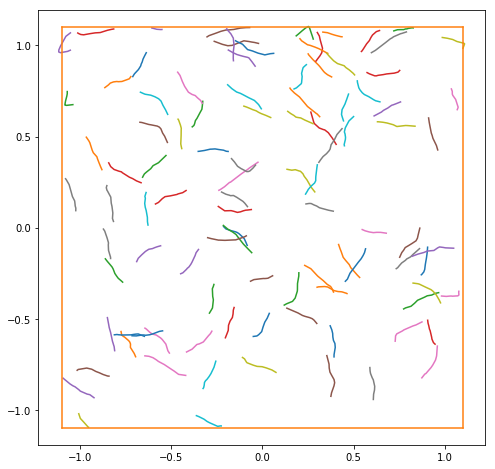

In [27]:
def plot_sample_trajs(num_traj):
    plt.figure(figsize=(8,8))
    for i in range(num_traj):
        traj = generate_trajectory(dt, samples, box_size, sigma, b, mu)
        x = traj['target_x']
        y = traj['target_y']
        plt.plot(x, y)

    # Plot box
    plt.axis("equal")    
    plt.plot(np.linspace(-box_size, box_size, 2),np.ones(2)*-box_size, c='C1')
    plt.plot(np.linspace(-box_size, box_size, 2),np.ones(2)*box_size, c='C1')
    plt.plot(np.ones(2)*-box_size,np.linspace(-box_size, box_size, 2), c='C1')
    plt.plot(np.ones(2)*box_size,np.linspace(-box_size, box_size, 2), c='C1')
    
plot_sample_trajs(100)

In [28]:
# Generate and save dataset
num_files = 100
num_trajectories = 100
data_name = '10_step_new'
datafile = 'data/' + data_name

# Make directory
import os
if not os.path.exists(datafile):
    os.mkdir(datafile)

def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

for i in tqdm(range(num_files)):
    filename = datafile + '/' + str(i) + '.tfrecord'
    with tf.python_io.TFRecordWriter(filename) as writer:
        for j in range(num_trajectories):
            traj = generate_trajectory(dt, samples, box_size, sigma, b, mu)
            feature = {
                'init_x': _floats_feature([traj['init_x']]),
                'init_y': _floats_feature([traj['init_y']]),
                'init_hd': _floats_feature([traj['init_hd']]),
                'ego_v': _floats_feature(traj['ego_v']),
                'phi_x': _floats_feature(traj['phi_x']),
                'phi_y': _floats_feature(traj['phi_y']),
                'target_x': _floats_feature(traj['target_x']),
                'target_y': _floats_feature(traj['target_y']),
                'target_hd': _floats_feature(traj['target_hd'])
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())


# Rectangular box periodic

In [2]:
# Set up trajectory parameters
dt = 0.02  # time step increment (seconds)
samples = 10  # number of time points
box_size_x = 1.1 #meters
box_size_y = 0.7

sigma = 5.76 * 2  # stdev rotation velocity (rads/sec)
b = 0.13 * 2 * np.pi # forward velocity rayleigh dist scale (m/sec)
mu = 0  # turn angle bias 

In [3]:
def generate_trajectory(dt, samples, box_size_x, box_size_y, sigma, b, mu):
    '''Generate a random walk in a square, periodic box'''
    # Initialize variables
    position = np.zeros([samples+2, 2])
    head_dir = np.zeros(samples+2)
    turning = np.zeros(samples+2, dtype='bool')
    position[0,0] = np.random.uniform(-box_size_x, box_size_x)
    position[0,1] = np.random.uniform(-box_size_y, box_size_y)
    head_dir[0] = np.random.uniform(0,2*np.pi)
    velocity = np.zeros(samples+2)
    
    # Generate sequence of random boosts and turns
    random_turn = np.random.normal(mu, sigma, samples+2)
    random_vel = np.random.rayleigh(b, samples+2)
    
    for i in range(samples+1):
        #Take a step
        v = random_vel[i]
        velocity[i] = v*dt
        update = velocity[i]*np.asarray([np.cos(head_dir[i]), np.sin(head_dir[i])])
        position[i+1] = position[i] + update
        
        #Rotate head direction
        turn_angle = dt*random_turn[i]
        head_dir[i+1] = (head_dir[i] + turn_angle)
        
    position[:,0] = np.mod(position[:,0] + box_size_x, 2*box_size_x) - box_size_x  # Periodic boundaries 
    position[:,1] = np.mod(position[:,1] + box_size_y, 2*box_size_y) - box_size_y
    head_dir = np.mod(head_dir + np.pi, 2*np.pi) - np.pi # Periodic variable
       
    traj = {}
    # Input variables
    traj['init_hd'] = head_dir[0]
    traj['init_x'] = position[1,0]
    traj['init_y'] = position[1,1]
    
    traj['ego_v'] = velocity[1:-1]
    ang_v = np.diff(head_dir)
    traj['phi_x'], traj['phi_y'] = np.cos(ang_v)[:-1], np.sin(ang_v)[:-1]
    
    # Target variables
    traj['target_hd'] = head_dir[1:-1]
    traj['target_x'] = position[2:,0]
    traj['target_y'] = position[2:,1]
    
    return traj

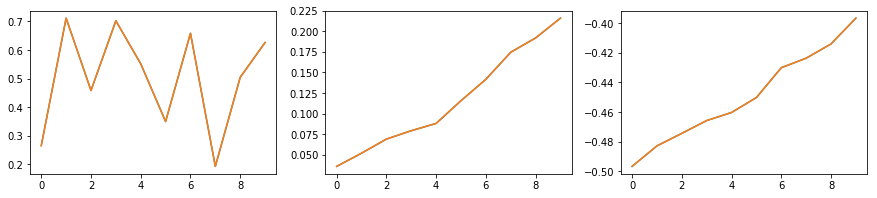

In [4]:
# Manually check path integration
traj = generate_trajectory(dt, samples, box_size_x, box_size_y, sigma, b, mu)

phi = np.arctan2(traj['phi_y'], traj['phi_x'])
phi = np.mod(phi + np.pi, 2*np.pi) - np.pi
hd_est = traj['init_hd'] + np.cumsum(phi)
x_est = traj['init_x'] + np.cumsum(traj['ego_v']*np.cos(hd_est))
x_est = np.mod(x_est + box_size_x, 2*box_size_x) - box_size_x
y_est = traj['init_y'] + np.cumsum(traj['ego_v']*np.sin(hd_est))
y_est = np.mod(y_est + box_size_y, 2*box_size_y) - box_size_y

plt.figure(figsize=(15,3))
plt.subplot(131)
plt.plot(traj['target_hd'])
plt.plot(hd_est)
plt.subplot(132)
plt.plot(traj['target_x'])
plt.plot(x_est)
plt.subplot(133)
plt.plot(traj['target_y'])
plt.plot(y_est)
plt.show()

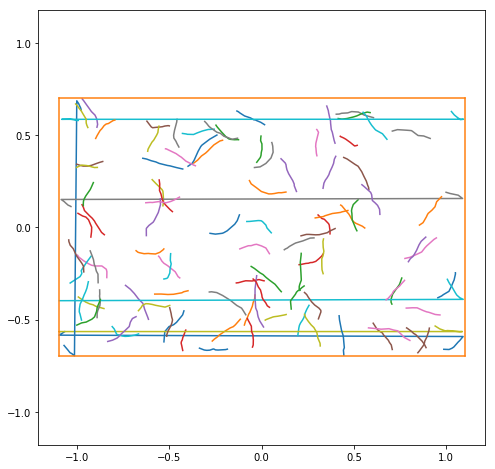

In [6]:
def plot_sample_trajs(num_traj):
    plt.figure(figsize=(8,8))
    for i in range(num_traj):
        traj = generate_trajectory(dt, samples, box_size_x, box_size_y, sigma, b, mu)
        x = traj['target_x']
        y = traj['target_y']
        plt.plot(x, y)

    # Plot box
    plt.axis("equal")    
    plt.plot(np.linspace(-box_size_x, box_size_x, 2),np.ones(2)*-box_size_y, c='C1')
    plt.plot(np.linspace(-box_size_x, box_size_x, 2),np.ones(2)*box_size_y, c='C1')
    plt.plot(np.ones(2)*-box_size_x,np.linspace(-box_size_y, box_size_y, 2), c='C1')
    plt.plot(np.ones(2)*box_size_x,np.linspace(-box_size_y, box_size_y, 2), c='C1')
    
plot_sample_trajs(100)

In [7]:
# Generate and save dataset
num_files = 100
num_trajectories = 100
data_name = '10_step_periodic_rectangle_07'
datafile = 'data/' + data_name

# Make directory
import os
if not os.path.exists(datafile):
    os.mkdir(datafile)

def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

for i in tqdm(range(num_files)):
    filename = datafile + '/' + str(i) + '.tfrecord'
    with tf.python_io.TFRecordWriter(filename) as writer:
        for j in range(num_trajectories):
            traj = generate_trajectory(dt, samples, box_size_x, box_size_y, sigma, b, mu)
            feature = {
                'init_x': _floats_feature([traj['init_x']]),
                'init_y': _floats_feature([traj['init_y']]),
                'init_hd': _floats_feature([traj['init_hd']]),
                'ego_v': _floats_feature(traj['ego_v']),
                'phi_x': _floats_feature(traj['phi_x']),
                'phi_y': _floats_feature(traj['phi_y']),
                'target_x': _floats_feature(traj['target_x']),
                'target_y': _floats_feature(traj['target_y']),
                'target_hd': _floats_feature(traj['target_hd'])
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())


# Square box w/ hd integration

In [2]:
def min_dist_angle(position, direction, box_size):
    #which wall is it close to?
    x, y = position
    dists = [box_size-x, box_size-y, box_size+x, box_size+y]
    d_wall = np.min(dists)
    angles = np.arange(4)*np.pi/2
    theta = angles[np.argmin(dists)]
    a_wall = direction - theta
    a_wall = (a_wall + np.pi) % (2*np.pi) - np.pi
    return d_wall, a_wall

In [6]:
# Set up trajectory params
dt = 0.02  # time step increment (seconds)
samples = int(2/dt) + 1  # number of time points
box_size = 1.1 #meters
border_region = 0.03  # meters

turn_angle = 0

mu = 0
sigma = 5.76 * 2  # stdev rotation velocity (rads/sec)
b = 0.13 * 2 * np.pi # forward velocity rayleigh dist scale (m/sec)

In [41]:
# random velocity samples
def generate_trajectory():
    v = np.random.rayleigh(b);
    #initialize variables
    position = np.zeros([samples+1, 2])
    head_dir = np.zeros(samples+1)
    turning = np.zeros(samples+1, dtype='bool')

    position[0] = np.random.uniform(-box_size, box_size, 2)
    head_dir[0] = np.random.uniform(0,2*np.pi)
    ego_v = np.zeros(samples+1)
    
    #generate sequence of random boosts and turns
    random_turn = np.random.normal(mu, sigma, samples+1)
    random_vel = np.random.rayleigh(b, samples+1)
    
    for i in range(1,samples+1):
        v = random_vel[i]
        turn_angle = dt*random_turn[i]
        #Take a step
        ego_v[i-1] = v*dt
        position[i] = position[i-1] + ego_v[i-1]*np.asarray([np.cos(head_dir[i-1]), np.sin(head_dir[i-1])])
        position[i] = np.mod(position[i] + box_size, 2*box_size) - box_size  # for periodic boundaries
        
        #Rotate head direction
        head_dir[i] = (head_dir[i-1] + turn_angle) 
        
    x0 = position[0,0]
    y0 = position[0,0]
    target_x = position[1:,0]
    target_y = position[1:,1]
    dx = position[1:,0] - position[:-1,0]
    dy = position[1:,1] - position[:-1,1]
    
    ang_velocity = np.diff(head_dir)
    theta_x, theta_y = np.cos(ang_velocity), np.sin(ang_velocity)
    head_dir = (head_dir+np.pi) % (2*np.pi) - np.pi #Constrain head_dir to interval (-pi, pi)
    
    return x0, y0, target_x, target_y, head_dir, ego_v, theta_x, theta_y

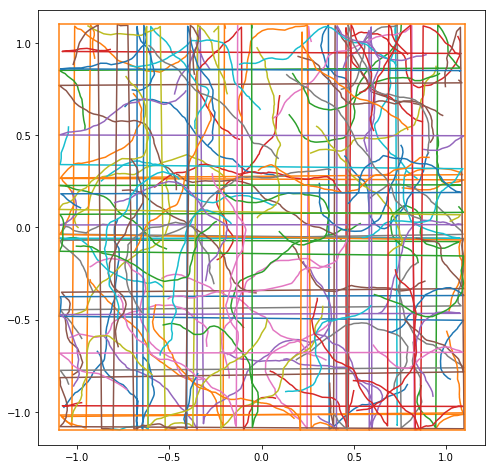

In [53]:
def plot_sample_trajs(num_traj):
    plt.figure(figsize=(8,8))
    for i in range(num_traj):
        x, y, hd, ego_v[:-1], theta_x, theta_y = generate_trajectory()
        plt.plot(x, y)

    plt.axis("equal")    
#     t = np.linspace(-np.pi, np.pi, 100)
#     plt.plot(box_size*np.cos(t), box_size*np.sin(t))

    plt.plot(np.linspace(-box_size, box_size, 2),np.ones(2)*-box_size, c='C1')
    plt.plot(np.linspace(-box_size, box_size, 2),np.ones(2)*box_size, c='C1')
    plt.plot(np.ones(2)*-box_size,np.linspace(-box_size, box_size, 2), c='C1')
    plt.plot(np.ones(2)*box_size,np.linspace(-box_size, box_size, 2), c='C1')
#     plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    
plot_sample_trajs(100)

In [54]:
import os
os.mkdir('data/50_step_periodic_test')

In [56]:
x, y, hd, ego_v[:-1], theta_x, theta_y = generate_trajectory()

In [57]:
x.shape

(51,)

In [11]:
# Generate dataset
def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

num_files = 10
num_trajectories = 100
for i in tqdm(range(num_files)):
    root = 'data/'
    filename = root + '50_step_periodic/' + str(i) + '.tfrecord'
#     box_size = 1.1
#     box_size = box_sizes[i]
#     sigma = 5.76 * np.mod(i, 2)
    with tf.python_io.TFRecordWriter(filename) as writer:
        for j in range(num_trajectories):
            x, y, hd, ego_v[:-1], theta_x, theta_y = generate_trajectory()
#             traj = traj[:,::10] # Decimate to approximately match deepmind

            feature = {
                'init_x': _floats_feature([x[0]]),
                'init_y': _floats_feature([x[1]]),
                'init_hd': _floats_feature([traj[2][0]]),
                'ego_v': _floats_feature(traj[3][:-1]),
                'ego_hd': _floats_feature(traj[3][:-1]),
                'theta_x': _floats_feature(traj[4][:-1]),
                'theta_y': _floats_feature(traj[5][:-1]),
                'target_x': _floats_feature(traj[0][1:]),
                'target_y': _floats_feature(traj[1][1:]),
                'target_hd': _floats_feature(traj[2][1:])
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())


# Circular box

In [3]:
def min_dist_angle_circular(position, direction, box_size):
    #which wall is it close to?
    x, y = position
    r = np.sqrt(x**2 + y**2)
    d_wall = box_size - r

    # find nearest point on circle
    x_circ = x*box_size / r
    y_circ = y*box_size / r

    # compute angle to this point
    theta = np.arctan2(y_circ, x_circ) % (2*np.pi)

    # subtract from head direction to get a_wall
    a_wall = direction - theta
    a_wall = (a_wall + np.pi) % (2*np.pi) - np.pi
    
    return d_wall, a_wall

In [6]:
# Set up trajectory params
dt = 0.02  # time step increment (seconds)
samples = int(2/dt) + 1  # number of time points
box_size = 1.1 #meters
border_region = 0.03  # meters

turn_angle = 0

mu = 0
sigma = 5.76 * 2  # stdev rotation velocity (rads/sec)
b = 0.13 * 2 * np.pi # forward velocity rayleigh dist scale (m/sec)

In [7]:
samples=51

In [49]:
# random velocity samples
def generate_trajectory():
    v = np.random.rayleigh(b);
    #initialize variables
    position = np.zeros([samples+1, 2])
    head_dir = np.zeros(samples+1)
    turning = np.zeros(samples+1, dtype='bool')
    
    # For generating circular trajectory
#     init_rad = np.random.uniform(0, 1.1)
#     init_ang = np.random.uniform(0, 2*np.pi)
#     position[0] = init_rad * np.asarray([np.cos(init_ang), np.sin(init_ang)])
    
    position[0] = np.random.uniform(-box_size, box_size, 2)
    head_dir[0] = np.random.uniform(0,2*np.pi)
    ego_v = np.zeros(samples+1)
    
    #generate sequence of random boosts and turns
    random_turn = np.random.normal(mu, sigma, samples+1)
    random_vel = np.random.rayleigh(b, samples+1)
    
    # stop at random times for 10 iters
#     stop_idx = np.random.randint(samples)
#     random_vel[stop_idx:stop_idx+5] = 0
    
    for i in range(1,samples+1):
        #If in border region, turn and slow down
#         d_wall, a_wall = min_dist_angle(position[i-1], head_dir[i-1] % (2*np.pi), box_size)
#         if d_wall < border_region and np.abs(a_wall) < np.pi/2:
#             turning[i-1] = 1 
#             turn_angle = np.sign(a_wall)* (np.pi/2 - np.abs(a_wall)) + dt*random_turn[i]
#             v = 0.25*v
#         else:
        v = random_vel[i]
        turn_angle = dt*random_turn[i]
        #Take a step
        ego_v[i-1] = v*dt
        position[i] = position[i-1] + ego_v[i-1]*np.asarray([np.cos(head_dir[i-1]), np.sin(head_dir[i-1])])
        position[i] = np.mod(position[i] + 1.1, 2.2) - 1.1  # for periodic boundaries
        
        #Rotate head direction
        head_dir[i] = (head_dir[i-1] + turn_angle) 
    ang_velocity = np.diff(head_dir)
    theta_x, theta_y = np.cos(ang_velocity), np.sin(ang_velocity)
    head_dir = (head_dir +np.pi) % (2*np.pi) - np.pi #Constrain head_dir to interval (-pi, pi)
    return position[:-1,0], position[:-1, 1], head_dir[:-1], ego_v[:-1], theta_x, theta_y, turning[:-1]

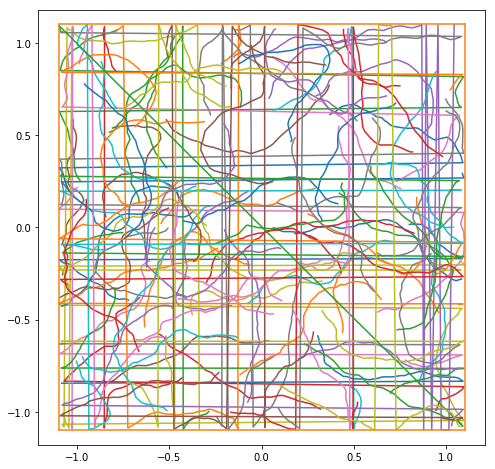

In [9]:
def plot_sample_trajs(num_traj):
    plt.figure(figsize=(8,8))
    for i in range(num_traj):
        sample_traj = generate_trajectory()
        x = sample_traj[0]
        y = sample_traj[1]
        turning = sample_traj[-1]
        plt.plot(x, y)
        plt.scatter(x[turning], y[turning], c='red')

    plt.axis("equal")    
#     t = np.linspace(-np.pi, np.pi, 100)
#     plt.plot(box_size*np.cos(t), box_size*np.sin(t))

    plt.plot(np.linspace(-box_size, box_size, 2),np.ones(2)*-box_size, c='C1')
    plt.plot(np.linspace(-box_size, box_size, 2),np.ones(2)*box_size, c='C1')
    plt.plot(np.ones(2)*-box_size,np.linspace(-box_size, box_size, 2), c='C1')
    plt.plot(np.ones(2)*box_size,np.linspace(-box_size, box_size, 2), c='C1')
#     plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    
plot_sample_trajs(100)

In [10]:
import os
os.mkdir('data/50_step_periodic')

In [11]:
# Generate dataset
def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

num_files = 10
num_trajectories = 100
for i in tqdm(range(num_files)):
    root = 'data/'
    filename = root + '50_step_periodic/' + str(i) + '.tfrecord'
#     box_size = 1.1
#     box_size = box_sizes[i]
#     sigma = 5.76 * np.mod(i, 2)
    with tf.python_io.TFRecordWriter(filename) as writer:
        for j in range(num_trajectories):
            traj = np.asarray(generate_trajectory())
#             traj = traj[:,::10] # Decimate to approximately match deepmind

            feature = {
                'init_x': _floats_feature([traj[0][0]]),
                'init_y': _floats_feature([traj[1][0]]),
                'init_hd': _floats_feature([traj[2][0]]),
                'ego_v': _floats_feature(traj[3][:-1]),
                'theta_x': _floats_feature(traj[4][:-1]),
                'theta_y': _floats_feature(traj[5][:-1]),
                'target_x': _floats_feature(traj[0][1:]),
                'target_y': _floats_feature(traj[1][1:]),
                'target_hd': _floats_feature(traj[2][1:])
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())


# Rhomboid box

In [3]:
# Set up trajectory params
dt = 0.02  # time step increment (seconds)
samples = int(2/dt) + 1  # number of time points
box_size = 1.1 #meters
border_region = 0.03  # meters

turn_angle = 0

mu = 0
sigma = 5.76 * 2  # stdev rotation velocity (rads/sec)
b = 0.13 * 2 * np.pi # forward velocity rayleigh dist scale (m/sec)

In [13]:
# random velocity samples
def generate_trajectory():
    v = np.random.rayleigh(b);
    #initialize variables
    position = np.zeros([samples+1, 2])
    head_dir = np.zeros(samples+1)
    turning = np.zeros(samples+1, dtype='bool')
    
    # For generating circular trajectory
#     init_rad = np.random.uniform(0, 1.1)
#     init_ang = np.random.uniform(0, 2*np.pi)
#     position[0] = init_rad * np.asarray([np.cos(init_ang), np.sin(init_ang)])
    
    p0 = np.random.uniform(0, 1, 2)
    p0[0,p0[1] > np.sqrt(3)*p0[0]] += 1
    position[0] = p0*2*box_size - box_size
    head_dir[0] = np.random.uniform(0,2*np.pi)
    ego_v = np.zeros(samples+1)
    
    #generate sequence of random boosts and turns
    random_turn = np.random.normal(mu, sigma, samples+1)
    random_vel = np.random.rayleigh(b, samples+1)
    
    # stop at random times for 10 iters
#     stop_idx = np.random.randint(samples)
#     random_vel[stop_idx:stop_idx+5] = 0
    
    for i in range(1,samples+1):
        v = random_vel[i]
        turn_angle = dt*random_turn[i]
        
        #Take a step
        ego_v[i-1] = v*dt
        position[i] = position[i-1] + ego_v[i-1]*np.asarray([np.cos(head_dir[i-1]), np.sin(head_dir[i-1])])
        p = (position[i] + box_size)/(2*box_size)
        p = np.mod(p, 1)
        p[0,p[1] > np.sqrt(3)*p[0]] += 1
        p = p*2*box_size - box_size
        position[i] = p
        
        #Rotate head direction
        head_dir[i] = (head_dir[i-1] + turn_angle) 
    ang_velocity = np.diff(head_dir)
    theta_x, theta_y = np.cos(ang_velocity), np.sin(ang_velocity)
    head_dir = (head_dir +np.pi) % (2*np.pi) - np.pi #Constrain head_dir to interval (-pi, pi)
    return position[:-1,0], position[:-1, 1], head_dir[:-1], ego_v[:-1], theta_x, theta_y, turning[:-1]

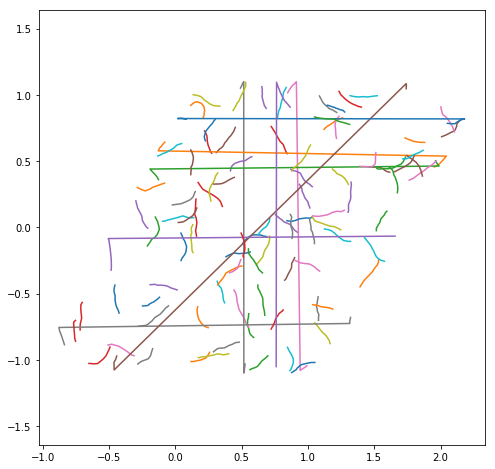

In [17]:
def plot_sample_trajs(num_traj):
    plt.figure(figsize=(8,8))
    for i in range(num_traj):
        sample_traj = generate_trajectory()
        x = sample_traj[0]
        y = sample_traj[1]
        turning = sample_traj[-1]
        plt.plot(x, y)
        plt.scatter(x[turning], y[turning], c='red')

    plt.axis("equal")    
#     t = np.linspace(-np.pi, np.pi, 100)
#     plt.plot(box_size*np.cos(t), box_size*np.sin(t))

#     plt.plot(np.linspace(-box_size, box_size, 2),np.ones(2)*-box_size, c='C1')
#     plt.plot(np.linspace(-box_size, box_size, 2),np.ones(2)*box_size, c='C1')
#     plt.plot(np.ones(2)*-box_size,np.linspace(-box_size, box_size, 2), c='C1')
#     plt.plot(np.ones(2)*box_size,np.linspace(-box_size, box_size, 2), c='C1')
#     plt.xlim([-1.2, 1.2])
#     plt.ylim([-1.2, 1.2])
    
plot_sample_trajs(100)

In [10]:
import os
os.mkdir('data/50_step_periodic')

In [11]:
# Generate dataset
def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

num_files = 10
num_trajectories = 100
for i in tqdm(range(num_files)):
    root = 'data/'
    filename = root + '50_step_periodic/' + str(i) + '.tfrecord'
#     box_size = 1.1
#     box_size = box_sizes[i]
#     sigma = 5.76 * np.mod(i, 2)
    with tf.python_io.TFRecordWriter(filename) as writer:
        for j in range(num_trajectories):
            traj = np.asarray(generate_trajectory())
#             traj = traj[:,::10] # Decimate to approximately match deepmind

            feature = {
                'init_x': _floats_feature([traj[0][0]]),
                'init_y': _floats_feature([traj[1][0]]),
                'init_hd': _floats_feature([traj[2][0]]),
                'ego_v': _floats_feature(traj[3][:-1]),
                'theta_x': _floats_feature(traj[4][:-1]),
                'theta_y': _floats_feature(traj[5][:-1]),
                'target_x': _floats_feature(traj[0][1:]),
                'target_y': _floats_feature(traj[1][1:]),
                'target_hd': _floats_feature(traj[2][1:])
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())


# Meta-learning

In [9]:
from place_cells import PlaceCells
from hd_cells import HDCells
from options import get_options

In [10]:
flags = get_options()

place_cells = PlaceCells(
    n_cells=flags.num_place_cells,
    std=flags.place_cell_rf,
    pos_min=-flags.env_size,
    pos_max=flags.env_size,
    DOG=flags.DOG
)
hd_cells = HDCells(
    n_cells=flags.num_hd_cells
)

In [31]:
def place_activation(pos):
    d = pos[np.newaxis, :, :] - place_cells.us[:, :, np.newaxis]
    norm2 = np.sum(d**2, axis=1)
    unnor_logpdf = -(norm2) / (2.0 * place_cells.sigma_sq)
    
    outputs = np.exp(unnor_logpdf) / np.sum(np.exp(unnor_logpdf), axis=0)
        
    if flags.DOG:
        logpdf2 = -(norm2) / (2.0 * 3 * place_cells.sigma_sq)
        outputs -= np.exp(logpdf2) / np.sum(np.exp(logpdf2), axis=0)
        outputs += np.abs(np.min(outputs, axis=0, keepdims=True))
        outputs /= np.sum(outputs, axis=0, keepdims=True)
        
    return outputs 

def hd_activation(angle):
    d = angle[np.newaxis, :] - hd_cells.us[:, np.newaxis]
    unnor_logpdf = hd_cells.concentration * np.cos(d)
    return np.exp(unnor_logpdf) / np.sum(np.exp(unnor_logpdf), axis=0)

def get_cell_outputs(traj):

    place_init = place_activation(traj[:2, 0][:, np.newaxis])
    hd_init = np.squeeze(hd_activation(np.expand_dims(traj[2,0], axis=1)))
    place_outputs = place_activation(traj[:2, 1:])
    hd_outputs = hd_activation(traj[2, 1:])

    return place_init, hd_init, place_outputs, hd_outputs

In [32]:
traj = np.asarray(generate_trajectory())
place_init, hd_init, place_outputs, hd_outputs = get_cell_outputs(traj)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [35]:
box_sizes = 1.1 * np.linspace(0.5,1,10)
np.random.shuffle(box_sizes)  # randomly shuffle order

# set first box to original size
box_sizes[np.where(box_sizes==1.1)] = box_sizes[0]
box_sizes[0] = 1.1

In [14]:
import os
os.mkdir('ben_10_step_10_boxes_rf_2_DOG')

In [36]:
# Generate dataset
def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

num_files = 10
num_trajectories = 1000
for i in tqdm(range(num_files)):
    root = ''
    filename = root + 'ben_10_step_10_boxes_rf_2_DOG/' + str(i) + '.tfrecord'
    box_size = box_sizes[i]
    
    # Define new set of place, hd cells
    place_cells = PlaceCells(
        n_cells=flags.num_place_cells,
        std=flags.place_cell_rf,
        pos_min=-box_size,
        pos_max=box_size
    )
    hd_cells = HDCells(
        n_cells=flags.num_hd_cells
    )
    
    with tf.python_io.TFRecordWriter(filename) as writer:
        for j in range(num_trajectories):
            traj = np.asarray(generate_trajectory())
            place_init, hd_init, place_outputs, hd_outputs = get_cell_outputs(traj)

            feature = {
                'init_x': _floats_feature([traj[0][0]]),
                'init_y': _floats_feature([traj[1][0]]),
                'init_hd': _floats_feature([traj[2][0]]),
                'ego_v': _floats_feature(traj[3][:-1]),
                'theta_x': _floats_feature(traj[4][:-1]),
                'theta_y': _floats_feature(traj[5][:-1]),
                'target_x': _floats_feature(traj[0][1:]),
                'target_y': _floats_feature(traj[1][1:]),
                'target_hd': _floats_feature(traj[2][1:]),
                'place_init': _floats_feature(place_init),
                'hd_init': _floats_feature(hd_init),
                'place_outputs': _floats_feature(place_outputs.ravel(order='F')),
                'hd_outputs': _floats_feature(hd_outputs.ravel(order='F'))
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
